# Plot Parameter Analysis

Utilities to analyze experiment results: derive order completion percentage, summary stats, per-parameter box plots, and scenario mean scatter plots.


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy.stats as stats
from matplotlib.lines import Line2D

# Experiment parameters considered
PARAMETERS = [
    'num_cashiers',
    'num_packers',
    'num_cooks',
    'num_bussers',
    'pickup_shelf_capacity',
    'coffee_urn_size',
    'num_espresso_machines',
    'brew_time',
    'priority_packing'
]

REVENUE_COLUMN = 'total_profit'  # Using total_profit as revenue metric


In [55]:
def read_and_process_csv(csv_file: str) -> pd.DataFrame:
    """Read CSV, derive order completion percentage if missing, and drop rows without revenue."""
    df = pd.read_csv(csv_file)

    # Derive order completion percentage if not present
    if 'order_complete_percentage' not in df.columns and \
       'throughput_total' in df.columns and 'arrival_total' in df.columns:
        df['order_complete_percentage'] = df.apply(
            lambda row: (row['throughput_total'] / row['arrival_total'])
            if pd.notna(row['arrival_total']) and row['arrival_total'] != 0 else 0,
            axis=1
        )

    # Filter out rows missing revenue metric
    if REVENUE_COLUMN in df.columns:
        df = df[df[REVENUE_COLUMN].notna()]

    return df


In [56]:
def plot_parameter_vs_revenue(df: pd.DataFrame, param_name: str, revenue_col: str = REVENUE_COLUMN, output_dir: str = 'plots'):
    """Box plot of revenue by parameter value (with means, medians, whiskers, outliers)."""
    if param_name not in df.columns:
        print(f"Warning: Parameter '{param_name}' not found in CSV. Skipping.")
        return

    grouped_data = []
    param_values = []

    unique_params = df[param_name].unique()
    nan_present = pd.isna(unique_params).any()
    non_nan_params = [p for p in unique_params if pd.notna(p)]
    if df[param_name].dtype in [np.int64, np.float64]:
        non_nan_params = sorted(non_nan_params)
    unique_params_list = ([None] if nan_present else []) + non_nan_params

    for param_val in unique_params_list:
        if pd.isna(param_val):
            revenue_values = df[df[param_name].isna()][revenue_col].dropna().tolist()
        else:
            revenue_values = df[df[param_name] == param_val][revenue_col].dropna().tolist()
        if revenue_values:
            grouped_data.append(revenue_values)
            param_values.append(param_val)

    if not grouped_data:
        print(f"Warning: No data found for parameter '{param_name}'. Skipping.")
        return

    fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

    labels = []
    for x in param_values:
        if x is None or (isinstance(x, float) and pd.isna(x)):
            labels.append('None')
        else:
            labels.append(str(x))

    bp = ax.boxplot(
        grouped_data,
        tick_labels=labels,
        patch_artist=True,
        showmeans=True,
        meanline=True
    )

    for patch in bp['boxes']:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='black', linewidth=1.5)
    plt.setp(bp['means'], color='red', linewidth=2, linestyle='--')

    if param_name == 'priority_packing' or len(param_values) > 5:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='steelblue', lw=8, alpha=0.7, label='Box: Interquartile Range (25%-75%)'),
        Line2D([0], [0], color='black', lw=2, label='Line in Box: Median (50%)'),
        Line2D([0], [0], color='red', linestyle='--', lw=2, label='Red Dashed Line: Mean'),
        Line2D([0], [0], color='black', lw=1.5, label='Whiskers: Min/Max'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=6, linestyle='None', label='Outliers')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=9, framealpha=0.9)

    rep_counts = df.groupby(param_name)[revenue_col].count()
    min_reps = rep_counts.min()
    max_reps = rep_counts.max()
    info_text = f"Each box shows revenue distribution across {min_reps:.0f}-{max_reps:.0f} replications" if min_reps != max_reps else f"Each box shows revenue distribution across {min_reps:.0f} replications"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Revenue (Total Profit)', fontsize=12, fontweight='bold')
    ax.set_title(f'Revenue vs {param_name.replace("_", " ").title()}', fontsize=14, fontweight='bold', pad=20)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    filepath = output_path / f'{param_name}_vs_revenue.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {filepath}")


In [57]:
def create_all_plots(csv_file: str, output_dir: str = 'plots'):
    df = read_and_process_csv(csv_file)
    available_params = [p for p in PARAMETERS if p in df.columns]
    missing_params = [p for p in PARAMETERS if p not in df.columns]
    if missing_params:
        print(f"Missing parameters (not in CSV): {missing_params}")

    for param in available_params:
        plot_parameter_vs_revenue(df, param, revenue_col=REVENUE_COLUMN, output_dir=output_dir)
    print(f"All parameter plots saved to '{output_dir}'.")


In [58]:
def create_summary_statistics(csv_file: str):
    df = read_and_process_csv(csv_file)
    print("=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    print(f"Total rows: {len(df)}")
    print(f"Unique scenarios: {df['scenario_id'].nunique() if 'scenario_id' in df.columns else 'n/a'}")
    if 'scenario_id' in df.columns and 'replication' in df.columns:
        print(f"Replications per scenario: {df.groupby('scenario_id')['replication'].count().iloc[0]}")
    print("\nRevenue Statistics:")
    print(f"  Mean: ${df[REVENUE_COLUMN].mean():,.2f}")
    print(f"  Std:  ${df[REVENUE_COLUMN].std():,.2f}")
    print(f"  Min:  ${df[REVENUE_COLUMN].min():,.2f}")
    print(f"  Max:  ${df[REVENUE_COLUMN].max():,.2f}")
    print("\nParameter Ranges (available in CSV):")
    available_params = [p for p in PARAMETERS if p in df.columns]
    for param in available_params:
        unique_vals = df[param].unique()
        if len(unique_vals) > 0:
            try:
                sorted_vals = sorted([v for v in unique_vals if pd.notna(v)])
            except TypeError:
                sorted_vals = [v for v in unique_vals if pd.notna(v)]
            print(f"  {param}: {sorted_vals}")
    print("=" * 60)


In [59]:
def scenario_mean_by_param(csv_file: str, param_name: str, value_col: str = REVENUE_COLUMN, scenario_ids=None) -> pd.DataFrame:
    """Mean of a target column for each scenario grouped by a parameter value (optional scenario filter)."""
    df = read_and_process_csv(csv_file)
    if param_name not in df.columns:
        raise ValueError(f"Parameter '{param_name}' not found in data.")
    if value_col not in df.columns:
        raise ValueError(f"Value column '{value_col}' not found in data.")
    data = df
    if scenario_ids is not None:
        data = data[data['scenario_id'].isin(scenario_ids)]
    grouped = (
        data.groupby(['scenario_id', param_name])[value_col]
        .mean()
        .reset_index()
        .rename(columns={value_col: f"{value_col}_mean"})
    )
    return grouped


In [60]:
def plot_scenario_mean_by_param(csv_file: str, param_name: str, value_col: str = REVENUE_COLUMN, scenario_ids=None, output_dir: str = 'plots'):
    """Scatter plot: scenario-level mean of a target column vs parameter value."""
    means_df = scenario_mean_by_param(csv_file, param_name, value_col=value_col, scenario_ids=scenario_ids)
    if means_df.empty:
        print(f"No data to plot for param '{param_name}' with given scenario filter.")
        return

    # Ensure one row per scenario by averaging over replications
    agg_col = f"{value_col}_mean"
    if agg_col not in means_df.columns:
        print(f"Missing column {agg_col} in grouped data.")
        return
    means_df = means_df.groupby('scenario_id', as_index=False).agg({param_name: 'first', agg_col: 'mean'})

    fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
    is_numeric = pd.api.types.is_numeric_dtype(means_df[param_name])
    scenario_ids_unique = means_df['scenario_id'].unique()
    colors = plt.cm.tab10.colors

    if is_numeric:
        for idx, scenario in enumerate(sorted(scenario_ids_unique)):
            subset = means_df[means_df['scenario_id'] == scenario]
            color = colors[idx % len(colors)]
            ax.scatter(
                subset[param_name],
                subset[f"{value_col}_mean"],
                label=f"Scenario {scenario}",
                color=color,
                s=40,
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5,
            )
        ax.grid(True, linestyle='--', alpha=0.3)
    else:
        categories = list(dict.fromkeys(means_df[param_name].tolist()))
        x_pos = {cat: i for i, cat in enumerate(categories)}
        jitter = 0.08
        for idx, scenario in enumerate(sorted(scenario_ids_unique)):
            subset = means_df[means_df['scenario_id'] == scenario]
            color = colors[idx % len(colors)]
            xs = [x_pos[val] + (idx - len(scenario_ids_unique)/2)*jitter for val in subset[param_name]]
            ax.scatter(
                xs,
                subset[f"{value_col}_mean"],
                label=f"Scenario {scenario}",
                color=color,
                s=40,
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5,
            )
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels([str(v) for v in categories], rotation=45, ha='right')
        ax.grid(True, linestyle='--', alpha=0.3, axis='y')

    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel(f"Mean {value_col.replace('_', ' ').title()}", fontsize=12, fontweight='bold')
    ax.set_title(f"Scenario Mean of Top {len(scenario_ids)} Scenarios {value_col.replace('_', ' ').title()} by {param_name.replace('_', ' ').title()}", fontsize=14, fontweight='bold', pad=20)
    # Remove legend; instead, annotate points with scenario_id
    for _, row in means_df.iterrows():
        ax.annotate(int(row['scenario_id']), (row[param_name] if is_numeric else x_pos[row[param_name]], row[f"{value_col}_mean"]),
                    textcoords="offset points", xytext=(4,4), fontsize=7, color='black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    filepath = output_path / f"scenario_mean_{param_name}.png"
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {filepath}")


In [61]:
def plot_profit_vs_labour(csv_file: str, output_dir: str = 'plots', show = False, save = True):
    """Scatter of profit vs labour cost with regression line; color = staffing size."""
    df = read_and_process_csv(csv_file)
    required_cols = ['total_labour_costs', 'total_profit']
    if not all(c in df.columns for c in required_cols):
        print(f"Missing columns: {[c for c in required_cols if c not in df.columns]}")
        return

    # Estimate staffing size (sum of staffing columns if present)
    staff_cols = [c for c in ['num_cashiers', 'num_packers', 'num_cooks', 'num_bussers', 'num_dt_stations'] if c in df.columns]
    if staff_cols:
        df['staff_size'] = df[staff_cols].sum(axis=1)
    else:
        df['staff_size'] = 1  # fallback

    x = df['total_labour_costs']
    y = df['total_profit']

    fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
    sc = ax.scatter(x, y, c=df['staff_size'], cmap='viridis', alpha=0.8, edgecolors='black', linewidths=0.5, s=40)

    # Regression line (simple linear fit)
    coeffs = np.polyfit(x, y, deg=1)
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = np.polyval(coeffs, x_fit)
    ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=2, label='Linear fit')

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Staff size (sum of staffing columns)', fontsize=10)

    ax.set_xlabel('Total Labour Costs', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Profit', fontsize=12, fontweight='bold')
    ax.set_title('Profit vs Labour Cost', fontsize=14, fontweight='bold', pad=15)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, p: f'${v:,.0f}'))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, p: f'${v:,.0f}'))
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    if save:
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        filepath = output_path / 'profit_vs_labour.png'
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"Saved: {filepath}")
    if show:
        plt.show()
    plt.close()


In [62]:
def top_scenarios_by_param(csv_file: str, param_name: str, top_n: int = 5, descending: bool = True, extra_cols=None):
    df = read_and_process_csv(csv_file)
    if param_name not in df.columns:
        raise ValueError(f"Parameter '{param_name}' not found in data.")
    sorted_df = df.sort_values(param_name, ascending=not descending)
    top_ids = sorted_df.drop_duplicates('scenario_id').head(top_n)['scenario_id']
    return top_ids.tolist()

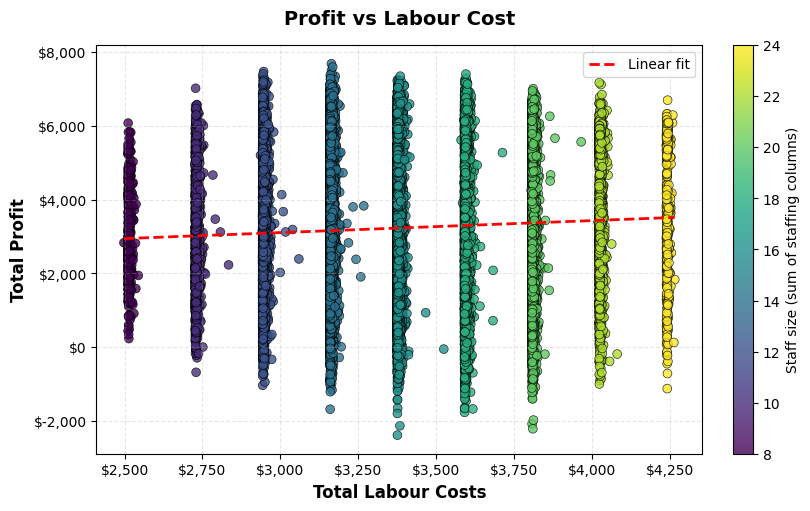

In [63]:
csv_file = "experiment_results_v7.csv"
output_dir = 'v7_plots'
plot_profit_vs_labour(csv_file, output_dir=output_dir, show=True, save=False)

In [64]:
def plot_annotated_heatmap(csv_file: str, x_param: str, y_param: str, value_col: str = 'total_profit', output_dir: str = 'plots', scenario_ids=None):
    """
    Annotated heatmap: X = x_param, Y = y_param, color = value_col, text = scenario_id.
    Uses the first occurrence per (scenario_id, x_param, y_param) to avoid duplication.
    Optional scenario_ids to filter which scenarios are shown/annotated.
    """
    df = read_and_process_csv(csv_file)
    for p in [x_param, y_param, value_col]:
        if p not in df.columns:
            print(f"Missing column: {p}")
            return

    if scenario_ids is not None:
        df = df[df['scenario_id'].isin(scenario_ids)]

    # Collapse to one row per scenario for the given params
    df_unique = df.drop_duplicates(subset=['scenario_id', x_param, y_param])

    # Pivot to matrix form
    pivot = df_unique.pivot_table(index=y_param, columns=x_param, values=value_col, aggfunc='mean')
    if pivot.empty:
        print("No data to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
    im = ax.imshow(pivot.values, cmap='viridis', aspect='auto')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(value_col.replace('_', ' ').title(), fontsize=10)

    # Tick labels
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticklabels(pivot.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Annotate with scenario IDs (where available)
    lookup = {}
    for _, row in df_unique.iterrows():
        key = (row[y_param], row[x_param])
        if key not in lookup:
            lookup[key] = row['scenario_id']

    for i, y_val in enumerate(pivot.index):
        for j, x_val in enumerate(pivot.columns):
            scenario_id = lookup.get((y_val, x_val))
            if scenario_id is not None and not pd.isna(pivot.values[i, j]):
                ax.text(j, i, int(scenario_id), ha='center', va='center', color='black', fontsize=7, fontweight='bold')

    ax.set_xlabel(x_param.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel(y_param.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_title(f"Heatmap: {value_col.replace('_', ' ').title()} by {x_param} vs {y_param}", fontsize=14, fontweight='bold', pad=15)
    ax.grid(False)

    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    filepath = output_path / f"heatmap_{x_param}_vs_{y_param}.png"
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {filepath}")


In [65]:
def plot_tornado_profit_swing(csv_file: str, param_list: list, output_dir: str = 'plots', output_name: str = 'tornado_profit_swing'):
    """
    Tornado chart: For each staffing role, plot the swing in profit between its min and max settings.
    Uses the observed min and max values in the CSV and computes mean profit at those extremes.
    Y-axis: role name
    X-axis: profit swing (max_mean_profit - min_mean_profit)
    """
    df = read_and_process_csv(csv_file)
    roles = param_list
    swings = []
    for role in roles:
        if role not in df.columns:
            continue
        vals = df[role].dropna().unique()
        if len(vals) < 2:
            continue
        min_val = vals.min()
        max_val = vals.max()
        min_mean_profit = df[df[role] == min_val]['total_profit'].mean()
        max_mean_profit = df[df[role] == max_val]['total_profit'].mean()
        swing = max_mean_profit - min_mean_profit
        swings.append((role, swing, min_mean_profit, max_mean_profit, min_val, max_val))

    if not swings:
        print("No roles with varying levels found.")
        return

    swings_sorted = sorted(swings, key=lambda x: abs(x[1]), reverse=True)
    roles_sorted = [r[0].replace('num_', '').replace('_', ' ').title() for r in swings_sorted]
    swing_values = [r[1] for r in swings_sorted]

    fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
    bars = ax.barh(roles_sorted, swing_values, color=['steelblue' if s >= 0 else 'salmon' for s in swing_values])

    for bar, swing, (role, s, min_p, max_p, min_v, max_v) in zip(bars, swing_values, swings_sorted):
        ax.text(bar.get_width() + (50 if swing >= 0 else -50), bar.get_y() + bar.get_height()/2,
                f"Δ${swing:,.0f}\n(min {min_v}→max {max_v})",
                va='center', ha='left' if swing >= 0 else 'right', fontsize=8)

    ax.set_xlabel('Profit Swing (Max - Min)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Role', fontsize=12, fontweight='bold')
    ax.set_title('Profit Swing by Staffing Role', fontsize=14, fontweight='bold', pad=15)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, p: f'${v:,.0f}'))
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)

    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    filepath = output_path / output_name
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {filepath}")


In [76]:
def rank_and_plot_bonferroni(csv_file, group_col='scenario_id', metric_col='total_profit', alpha=0.05, scenario_ids=None, output_dir='plots'):
    """
    Ranks scenarios, identifies statistically equivalent winners, and plots the top N results.
    """
    
    # --- STEP 1: The Math (Bonferroni Ranking) ---
    
    # Aggregate statistics per scenario (mean, std dev, count)
    df = read_and_process_csv(csv_file)
    df = df[df['scenario_id'].isin(scenario_ids)]
    summary = df.groupby(group_col)[metric_col].agg(['mean', 'std', 'count'])
    summary = summary.sort_values(by='mean', ascending=False)
    
    # Identify the "Leader" (Best Sample Mean)
    best_id = summary.index[0]
    best_mean = summary.loc[best_id, 'mean']
    best_std = summary.loc[best_id, 'std']
    best_n = summary.loc[best_id, 'count']
    
    # Calculate Bonferroni Corrected Alpha
    # We compare the Top 1 vs everyone else (k-1 comparisons)
    num_comparisons = len(summary) - 1
    corrected_alpha = alpha / num_comparisons
    
    results = []
    colors = []
    
    for sc_id, row in summary.iterrows():
        if sc_id == best_id:
            results.append("BEST (Ref)")
            colors.append("green") # Color for the Winner
            continue
            
        # Perform Welch's t-test (Best vs Current)
        t_stat, p_val = stats.ttest_ind_from_stats(
            mean1=best_mean, std1=best_std, nobs1=best_n,
            mean2=row['mean'], std2=row['std'], nobs2=row['count'],
            equal_var=False
        )
        
        # Determine status based on p-value
        if p_val < corrected_alpha:
            results.append("Worse")
            colors.append("lightgray") # Color for Losers
        else:
            results.append("Statistically Equivalent")
            colors.append("lime") # Color for Tied Winners
            
    summary['status'] = results
    summary['color'] = colors
    print(summary)
    # --- STEP 2: The Plotting ---
    
    # Filter to just the top N scenarios to keep the plot readable
    plot_data = summary
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate 95% Confidence Intervals for error bars
    # Formula: 1.96 * (std / sqrt(n))
    ci = 1.96 * (plot_data['std'] / np.sqrt(plot_data['count']))
    
    # Create the scatter plot with error bars
    y_pos = np.arange(len(plot_data))
    
    # 1. Draw the error bars first (so they are behind the dots)
    ax.errorbar(plot_data['mean'], y_pos, xerr=ci, fmt='none', ecolor='black', alpha=0.3, capsize=3)
    
    # 2. Draw the dots with specific colors
    ax.scatter(plot_data['mean'], y_pos, c=plot_data['color'], s=100, zorder=3)

    # Formatting the axes
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_data.index)
    ax.invert_yaxis() # Put the best scenario at the top
    ax.set_xlabel(f'Mean {metric_col} (with 95% CI)')
    ax.set_title(f'Top {len(scenario_ids)} Scenarios: Best vs. Statistically Equivalent\n(Bonferroni Corrected)')

    # Create a custom legend manually (since we plotted points individually)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Best Scenario'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=10, label='Statistically Equivalent'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10, label='Significantly Worse')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    filepath = output_path / f'bonferroni_ranking_{metric_col}.png'
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

    # Save the plot
    plt.close()
    print(f"Saved: {filepath}")


                    mean          std  count                    status  color
scenario_id                                                                  
644          7107.373499   289.149607      5                BEST (Ref)  green
621          7029.058062   433.610238      5  Statistically Equivalent   lime
1051         6940.992671   658.829643      5  Statistically Equivalent   lime
1149         6839.648899   333.086610      5  Statistically Equivalent   lime
860          6837.899366   278.759544      5  Statistically Equivalent   lime
643          6816.406122   300.921703      5  Statistically Equivalent   lime
1916         6815.186700   585.445429      5  Statistically Equivalent   lime
620          6804.204748   236.973975      5  Statistically Equivalent   lime
704          6775.110507   329.482823      5  Statistically Equivalent   lime
766          6735.816816   298.886549      5  Statistically Equivalent   lime
789          6732.080417   412.687044      5  Statistically Equi

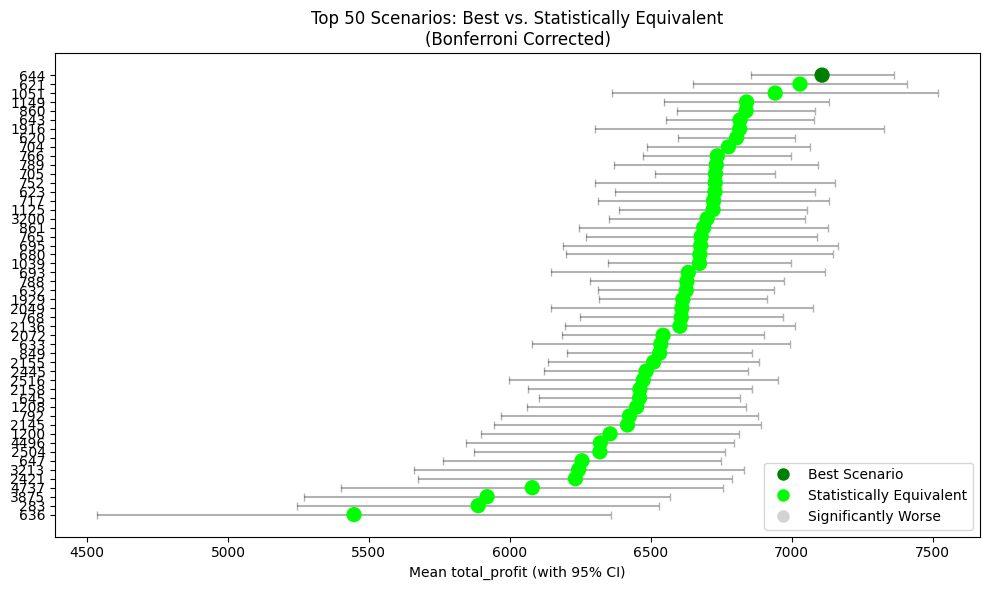

Saved: v7_plots\bonferroni_ranking_total_profit.png


In [77]:
# Example usage
csv_file = "experiment_results_v7.csv"  # change to your file
output_dir = 'v7_plots'
# # Summary
# create_summary_statistics(csv_file)

# # Per-parameter box plots
# create_all_plots(csv_file, output_dir=output_dir)

top = top_scenarios_by_param(csv_file, param_name='total_profit', top_n=50)
top

# plot_scenario_mean_by_param(csv_file, param_name='order_complete_percentage', value_col='total_profit', scenario_ids=top ,output_dir=output_dir)
# plot_annotated_heatmap(csv_file, x_param='num_cashiers', y_param='num_packers' ,value_col='total_profit', output_dir=output_dir)
# plot_profit_vs_labour(csv_file, output_dir=output_dir)
# plot_tornado_profit_swing(csv_file, param_list=PARAMETERS, output_dir=output_dir, output_name='tornado_profit_swing_all_params')
rank_and_plot_bonferroni(csv_file, scenario_ids=top, output_dir=output_dir)